In [0]:
import pandas as pd
from matplotlib import pyplot
from math import sqrt 
import numpy as np 
import scipy.misc 
from IPython.display import display 
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator 
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization,GlobalAveragePooling2D
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.optimizers import Adam, SGD
from keras.regularizers import l1, l2
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.utils import shuffle
%matplotlib inline
data=pd.read_pickle('../res/Images_data.pkl')
data=shuffle(data)
data.head()

Using TensorFlow backend.


,emotion,pixels,usage
817,0,28 28 35 50 60 59 70 88 107 120 126 116 96 80 ...,test
355,0,50 28 21 35 86 109 120 118 125 120 134 142 142...,train
881,0,156 184 170 163 160 83 18 28 76 128 160 170 16...,test
1133,1,205 99 21 71 116 142 152 184 180 163 167 173 1...,train
3055,2,227 248 128 28 73 73 60 80 78 42 76 116 120 95...,train


In [0]:
num_classes = 4
emotion_labels = ['Boredm','Confusion','Engagement','Frustration']
classes=np.array(('Boredm','Confusion','Engagement','Frustration'))

In [0]:
print(data.usage.value_counts() )
data.emotion.value_counts()

In [0]:
train_set = data[(data.usage == 'train')] 
train_set=shuffle(train_set)
val_set = data[(data.usage == 'test')]
val_set=shuffle(val_set)
X_train = np.array(list(map(str.split, train_set.pixels)), np.float32) 
X_val = np.array(list(map(str.split, val_set.pixels)), np.float32) 
X_train = X_train.reshape(X_train.shape[0], 48,48, 1) 
X_val = X_val.reshape(X_val.shape[0], 48,48, 1)

In [0]:
num_train = X_train.shape[0]
num_val = X_val.shape[0]

In [0]:
print(num_classes,num_train,num_val)

4 3047 760


In [0]:
y_train = train_set.emotion 
y_train = np_utils.to_categorical(y_train, num_classes) 
y_val = val_set.emotion 
y_val = np_utils.to_categorical(y_val, num_classes) 

In [0]:
datagen = ImageDataGenerator( 
    horizontal_flip = True,
    fill_mode = 'nearest')

testgen = ImageDataGenerator( 
    horizontal_flip = True
    )
batch_size = 64

In [0]:
train_flow = datagen.flow(X_train, y_train, batch_size=batch_size) 
val_flow = testgen.flow(X_val, y_val, batch_size=batch_size) 

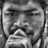

[0. 1. 0. 0.]


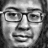

[0. 0. 1. 0.]


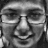

[0. 0. 1. 0.]


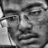

[1. 0. 0. 0.]


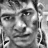

[0. 0. 0. 1.]


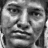

[0. 0. 1. 0.]


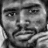

[0. 1. 0. 0.]


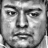

[0. 1. 0. 0.]


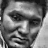

[0. 0. 0. 1.]


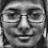

[0. 0. 1. 0.]


In [0]:
import random
from google.colab.patches import cv2_imshow
for i in range(10):
  m=random.randrange(760)
  k=X_val[m] 
  k=k.reshape((48,48,1))
  cv2_imshow(k)
  print(y_val[m])

In [0]:
from keras.models import Sequential
from keras import layers
from keras import models
from keras import optimizers
from keras import layers
from keras import models
from keras import optimizers
width=48
height=48
model = Sequential()
num_features=32
model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 1), data_format='channels_last', kernel_regularizer=l2(0.01)))
model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*num_features, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))
 


    

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 23, 23, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 23, 23, 64)       

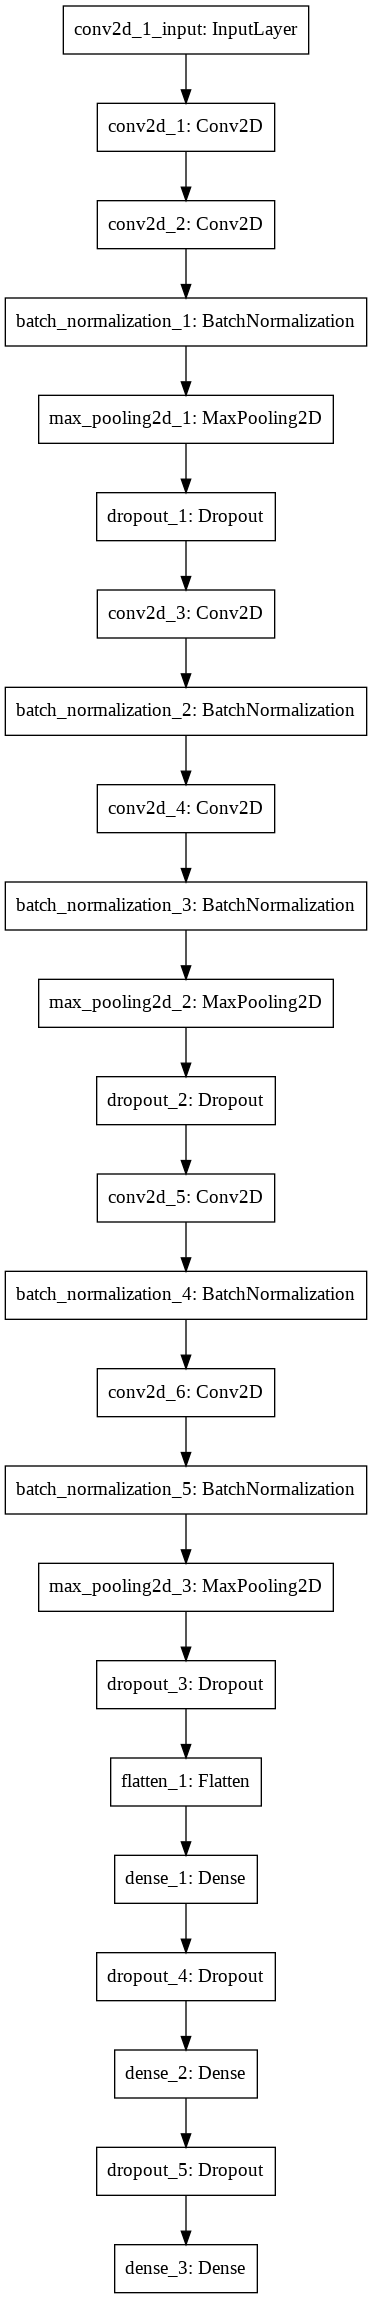

In [0]:
# optimizer:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
plot_model(
    model, to_file='../model_architecture.png', show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=True, dpi=96
)

In [0]:
class_Weights={0:0,1:1,2:2,3:3}
sum=0
k=data.emotion.value_counts()
for i in k:
  sum+=i
for i in range(len(k)):
  class_Weights[i]=sum/k[i]
print(class_Weights)

{0: 3.86497461928934, 1: 2.7747813411078717, 2: 4.360824742268041, 3: 6.59792027729636}


In [0]:
#fit
nb_epoch =200
batch_size = 64
history = model.fit(train_flow, epochs=nb_epoch,class_weight=class_Weights,
          validation_data=(X_val,y_val), shuffle=True, verbose=1)

Epoch 1/200
48/48 [==============================] - 52s 1s/step - loss: 8.0059 - accuracy: 0.2662 - val_loss: 1.4013 - val_accuracy: 0.2487
Epoch 2/200
48/48 [==============================] - 50s 1s/step - loss: 5.5774 - accuracy: 0.2379 - val_loss: 1.4069 - val_accuracy: 0.2408
Epoch 3/200
48/48 [==============================] - 50s 1s/step - loss: 5.5700 - accuracy: 0.2307 - val_loss: 1.4065 - val_accuracy: 0.2316
Epoch 4/200
48/48 [==============================] - 50s 1s/step - loss: 5.5644 - accuracy: 0.2304 - val_loss: 1.4058 - val_accuracy: 0.2303
Epoch 5/200
48/48 [==============================] - 51s 1s/step - loss: 5.5707 - accuracy: 0.2320 - val_loss: 1.4029 - val_accuracy: 0.2434
Epoch 6/200
48/48 [==============================] - 51s 1s/step - loss: 5.5672 - accuracy: 0.2314 - val_loss: 1.4036 - val_accuracy: 0.2553
Epoch 7/200
48/48 [==============================] - 51s 1s/step - loss: 5.5640 - accuracy: 0.2294 - val_loss: 1.4045 - val_accuracy: 0.2382
Epoch 8/200
4

In [0]:
model_1=Model(inputs=model.input,outputs=model.layers[-6].output)

In [0]:
from sklearn.svm import SVC
clf = SVC(kernel='linear', verbose=True,probability=True, tol=1e-3)

In [0]:
val_labs=np.asarray([np.argmax(i) for i in y_val])
train_labs=np.asarray([np.argmax(i) for i in y_train])

In [0]:
def plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=False,
                          title='Unnormalized confusion matrix',
                          cmap=plt.cm.Blues):
    cm = confusion_matrix(y_test, y_pred)
    
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        
    np.set_printoptions(precision=2)
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.min() + (cm.max() - cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True expression')
    plt.xlabel('Predicted expression')
    plt.show()

[LibSVM]time taken:  382.9979088306427


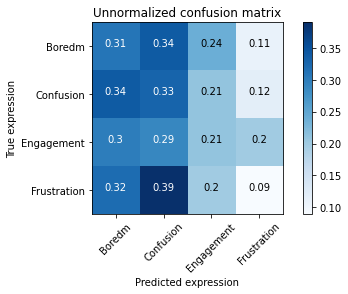

obtained_accuracy:  0.25921052631578945
[LibSVM]time taken:  385.48831963539124


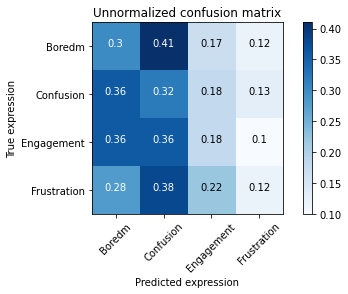

obtained_accuracy:  0.25526315789473686
[LibSVM]time taken:  381.08176279067993


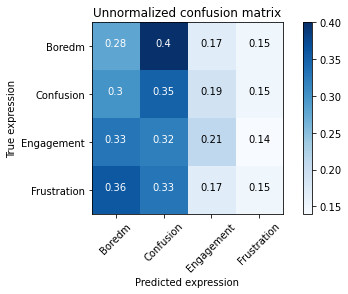

obtained_accuracy:  0.2710526315789474
[LibSVM]time taken:  384.01453161239624


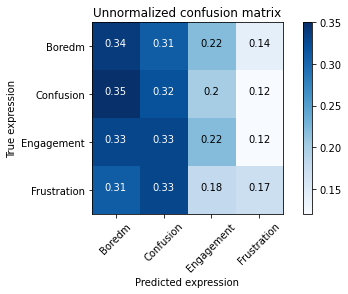

obtained_accuracy:  0.28157894736842104
[LibSVM]time taken:  388.88030529022217


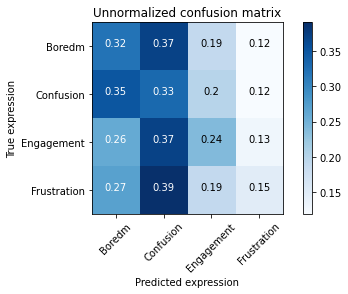

obtained_accuracy:  0.2789473684210526


In [0]:
import time
for i in range(5):
  s=time.time()
  extracted_features_train=model_1.predict(train_flow)
  extracted_features_val=model_1.predict(val_flow)
  clf.fit(extracted_features_train,train_labs)
  print('time taken: ',time.time()-s)
  pred_lin = clf.score(extracted_features_val,val_labs)
  plot_confusion_matrix(val_labs,clf.predict(extracted_features_val),classes,normalize=True)
  print('obtained_accuracy: ',pred_lin)

In [0]:
clf.fit(model_1.predict(X_train),train_labs)  #fitting the data with orogonal images

[LibSVM]

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=True)

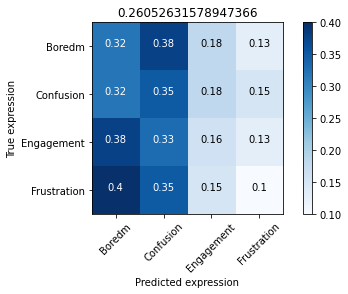

Obtained Accuracy for validation Set with agumentation 0.26052631578947366


In [0]:
extracted_features_val=model_1.predict(val_flow)     #testing on agumented Data
pred_labs=clf.predict(extracted_features_val)
plot_confusion_matrix(val_labs,pred_labs,classes,normalize=True,title=str(np.sum(pred_labs == val_labs)/len(val_labs)))
print('Obtained Accuracy for validation Set with agumentation',clf.score(extracted_features_val,val_labs))

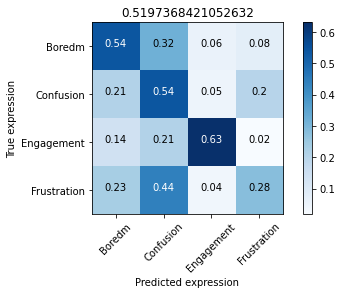

Obtained Accuracy for validation Set 0.5197368421052632


In [0]:
extracted_features_val=model_1.predict(X_val)      #testing on original validation set
pred_labs=clf.predict(extracted_features_val)
plot_confusion_matrix(val_labs,clf.predict(model_1.predict(X_val)),classes,normalize=True,title=str(np.sum(pred_labs == val_labs)/len(val_labs)))
print('Obtained Accuracy for validation Set',clf.score(extracted_features_val,val_labs))

In [0]:
model_1.save('../res/FER_Model.hdf5') #saving the model to extract features

In [0]:
from sklearn.externals import joblib
joblib.dump(clf,'../res/classifier_svm.pkl')    #saving the classifier

['/content/drive/My Drive/project/classifier_svm.pkl']

<Figure size 432x288 with 0 Axes>

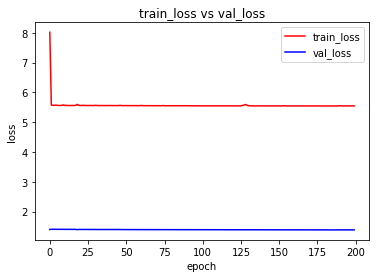

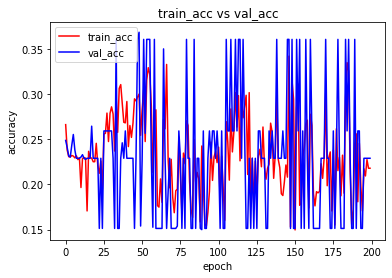

<Figure size 432x288 with 0 Axes>

In [0]:
# visualizing losses and accuracy
%matplotlib inline
train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.figure()

plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.figure()

In [0]:
loss = modelN.evaluate(X_val/255., y_val) 
print("Test Loss " + str(loss[0]))
print("Test Acc: " + str(loss[1]))